# LP für gemischt-ganzzahlige Optimierungsprobleme (MILP)
(Mixed-Integer Linear Program)

**HiGHS**

- Exakter Solver (Branch-and-Bound)
- HiGHS löst dein MILP per Simplex/Barrier‐Verfahren plus Branch-and-Bound.
- Wenn der Solver bis zum Time‐Limit läuft, liefert er eine (provably) optimale oder zumindest pareto‐optimale Lösung mit einer nachgewiesenen Lücke (Optimality Gap).

In [3]:
limit_minutes = 60*10   # 10h

## Minimierung der Flow Times der einzelnen Jobs

In [5]:
import pulp
import pandas as pd
from collections import defaultdict

### a) Ungewichtet

In [7]:
def solve_jssp_individual_flowtime(df_jssp: pd.DataFrame,
                                   df_arrivals: pd.DataFrame,
                                   solver_time_limit: int = 300,
                                   epsilon: float = 0.0):
    """
    Minimiert die Summe der individuellen Durchlaufzeiten (Flow Times) aller Jobs.
    Zielfunktion: sum_j (Endzeit_j - Arrival_j)

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals: DataFrame mit ['Job','Arrival'].
    - solver_time_limit: Max. Laufzeit für HiGHS (Sekunden).
    - epsilon: Puffer zwischen Operationen auf derselben Maschine.

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Machine',
      'Start','Processing Time','Flow time','End'].
    - total_flowtime: Summe aller Flow Times (float).
    """
    # Arrival-Lookup
    arrival = df_arrivals.set_index('Job')['Arrival'].to_dict()
    df = df_jssp.copy()

    # Modell
    prob = pulp.LpProblem('JSSP_IndFlow', pulp.LpMinimize)

    # Variablen
    starts = {
        (row.Job, row.Operation): pulp.LpVariable(f"start_{row.Job}_{row.Operation}", lowBound=0)
        for row in df.itertuples(index=False)
    }
    job_ends = {
        job: pulp.LpVariable(f"end_{job}", lowBound=0)
        for job in df['Job'].unique()
    }

    # Objective
    prob += pulp.lpSum(job_ends[j] - arrival[j] for j in job_ends)

    # Technologische Reihenfolge + Arrival
    for job, grp in df.groupby('Job', sort=False):
        seq = grp.sort_values('Operation').reset_index(drop=True)
        # erste Operation ≥ arrival
        prob += starts[(job, seq.loc[0, 'Operation'])] >= arrival[job]
        # Folge-OPs
        for i in range(len(seq)-1):
            op_prev = seq.loc[i, 'Operation']
            dur_prev = seq.loc[i, 'Processing Time']
            op_next = seq.loc[i+1, 'Operation']
            prob += starts[(job, op_next)] >= starts[(job, op_prev)] + dur_prev
        # letzte OP → job_end
        last_op = seq.loc[len(seq)-1, 'Operation']
        dur_last = seq.loc[len(seq)-1, 'Processing Time']
        prob += job_ends[job] >= starts[(job, last_op)] + dur_last

    # Maschinenkonflikte
    M = 1e6
    for machine, grp in df.groupby('Machine', sort=False):
        block = grp.reset_index(drop=True)
        for i in range(len(block)):
            for j in range(i+1, len(block)):
                ri = block.loc[i]
                rj = block.loc[j]
                if ri.Job == rj.Job:
                    continue
                si = starts[(ri.Job, ri.Operation)]
                sj = starts[(rj.Job, rj.Operation)]
                di = ri['Processing Time']
                dj = rj['Processing Time']
                y = pulp.LpVariable(f"y_{ri.Job}_{ri.Operation}_{rj.Job}_{rj.Operation}", cat='Binary')
                prob += si + di + epsilon <= sj + M*(1-y)
                prob += sj + dj + epsilon <= si + M*y

    # Lösen
    prob.solve(pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit))

    # Ergebnis
    recs = []
    for _, row in df.iterrows():
        st = starts[(row.Job, row.Operation)].varValue
        end = st + row['Processing Time']
        recs.append({
            'Job': row.Job,
            'Operation': row.Operation,
            'Arrival': arrival[row.Job],
            'Machine': row.Machine,
            'Start': round(st, 2),
            'Processing Time': row['Processing Time'],
            'Flow time': round(end - arrival[row.Job], 2),
            'End': round(end, 2)
        })

    df_schedule = pd.DataFrame(recs).sort_values(['Arrival','Start']).reset_index(drop=True)
    total_flowtime = round(pulp.value(prob.objective), 3)
    return df_schedule, total_flowtime


### b) Gewichtet

In [9]:
def solve_jssp_weighted_individual_flowtime(df_jssp: pd.DataFrame,
                                            df_arrivals: pd.DataFrame,
                                            solver_time_limit: int = 300,
                                            epsilon: float = 0.0):
    """
    Minimiert die gewichtete Summe der individuellen Durchlaufzeiten aller Jobs.
    Gewicht_j = 1 / (1 + Arrival_j)
    Zielfunktion: sum_j Gewicht_j * (Endzeit_j - Arrival_j)

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time'].
    - df_arrivals: DataFrame mit ['Job','Arrival'].
    - solver_time_limit: Max. Laufzeit für HiGHS (Sekunden).
    - epsilon: Puffer zwischen Operationen auf derselben Maschine.

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Machine',
      'Start','Processing Time','Flow time','End'], sortiert nach ['Arrival','Start'].
    - total_weighted_flowtime: gewichtete Summe der Durchlaufzeiten (float).
    """
    # Arrival lookup and weights
    arrival = df_arrivals.set_index('Job')['Arrival'].to_dict()
    weights = {job: 1.0 / (1.0 + arrival[job]) for job in arrival}

    df = df_jssp.copy()
    jobs = df['Job'].unique().tolist()

    # Initialize model
    prob = pulp.LpProblem('JSSP_Weighted_IndFlow', pulp.LpMinimize)

    # Start-time variables
    starts = {
        (row.Job, row.Operation): pulp.LpVariable(f"start_{row.Job}_{row.Operation}", lowBound=0)
        for row in df.itertuples(index=False)
    }
    # End-time per job
    job_end = {
        job: pulp.LpVariable(f"end_{job}", lowBound=0)
        for job in jobs
    }

    # Objective: weighted sum of (end - arrival)
    prob += pulp.lpSum(weights[j] * (job_end[j] - arrival[j]) for j in jobs)

    # Tech order + arrival
    for job, grp in df.groupby('Job', sort=False):
        seq = grp.sort_values('Operation').reset_index(drop=True)
        # first op ≥ arrival
        prob += starts[(job, seq.loc[0, 'Operation'])] >= arrival[job]
        # sequence constraints
        for i in range(len(seq) - 1):
            op_i = seq.loc[i, 'Operation']
            dur_i = seq.loc[i, 'Processing Time']
            op_n = seq.loc[i+1, 'Operation']
            prob += starts[(job, op_n)] >= starts[(job, op_i)] + dur_i
        # link last op to job_end
        last_op = seq.loc[len(seq)-1, 'Operation']
        last_dur = seq.loc[len(seq)-1, 'Processing Time']
        prob += job_end[job] == starts[(job, last_op)] + last_dur

    # Machine conflicts
    M = 1e6
    for machine, grp in df.groupby('Machine', sort=False):
        block = grp.reset_index(drop=True)
        for i in range(len(block)):
            for j in range(i+1, len(block)):
                ri = block.loc[i]
                rj = block.loc[j]
                if ri.Job == rj.Job:
                    continue
                si = starts[(ri.Job, ri.Operation)]
                sj = starts[(rj.Job, rj.Operation)]
                di = ri['Processing Time']
                dj = rj['Processing Time']
                y = pulp.LpVariable(f"y_{ri.Job}_{ri.Operation}_{rj.Job}_{rj.Operation}", cat='Binary')
                prob += si + di + epsilon <= sj + M*(1-y)
                prob += sj + dj + epsilon <= si + M*y

    # Solve
    prob.solve(pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit))

    # Extract schedule
    recs = []
    for _, row in df.iterrows():
        st = starts[(row.Job, row.Operation)].varValue
        end = st + row['Processing Time']
        recs.append({
            'Job': row.Job,
            'Operation': row.Operation,
            'Arrival': arrival[row.Job],
            'Machine': row.Machine,
            'Start': round(st, 2),
            'Processing Time': row['Processing Time'],
            'Flow time': round(end - arrival[row.Job], 2),
            'End': round(end, 2)
        })

    df_schedule = pd.DataFrame(recs) \
        .sort_values(['Arrival','Start']) \
        .reset_index(drop=True)

    total_weighted_flowtime = round(pulp.value(prob.objective), 3)
    return df_schedule, total_weighted_flowtime



### --------------------------------------------------------------------------

In [11]:
import sys, json
from pathlib import Path

# 1. Projekt-Root nur einmal bestimmen
PROJECT_ROOT = Path.cwd().parent.resolve()

# 2. sys.path fürs Importieren um PROJECT_ROOT erweitern
sys.path.insert(0, str(PROJECT_ROOT))

In [12]:
import pandas as pd
import utils.checker as check
import utils.basics.presenter as show
import utils.basics.converter as convert
import utils.schedule_interarrival as sit

In [13]:
data_file = Path(PROJECT_ROOT, "data/jobshop_instances.json")
# Datei laden
with open(data_file, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [14]:
u_b_mmax = 0.9  # 90% Auslastung (der Engpassmaschine)

mean_interarrival_time = sit.calculate_mean_interarrival_time(df_instance, u_b_mmax)
print(f"Mittlere Zwischenankunftszeit (bei Auslastung von {u_b_mmax:.0%}): {mean_interarrival_time} Minuten")
df_arrivals = sit.generate_job_arrivals_df_by_mean_interarrival_time(df_instance, t_a=mean_interarrival_time)
df_arrivals

Mittlere Zwischenankunftszeit (bei Auslastung von 90%): 70.11 Minuten


,Job,Arrival
0,job 0,0.00
1,job 1,84.93
2,job 2,106.18
3,job 3,148.31
4,job 4,185.08
5,job 5,251.37
6,job 6,312.71
7,job 7,329.63
8,job 8,344.30
9,job 9,429.20


### a) ungewichtet

In [16]:
df_schedule, _ = solve_jssp_individual_flowtime(df_instance, df_arrivals, solver_time_limit=60*limit_minutes, epsilon=0)
df_schedule

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,job 0,0,0.0,M0,0.00,29,29.00,29.00
1,job 0,1,0.0,M1,29.00,78,107.00,107.00
2,job 0,2,0.0,M2,107.00,9,116.00,116.00
3,job 0,3,0.0,M3,116.00,36,152.00,152.00
4,job 0,4,0.0,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
95,job 9,5,429.2,M9,876.08,76,522.88,952.08
96,job 9,6,429.2,M5,952.08,47,569.88,999.08
97,job 9,7,429.2,M3,999.08,52,621.88,1051.08
98,job 9,8,429.2,M4,1051.08,90,711.88,1141.08


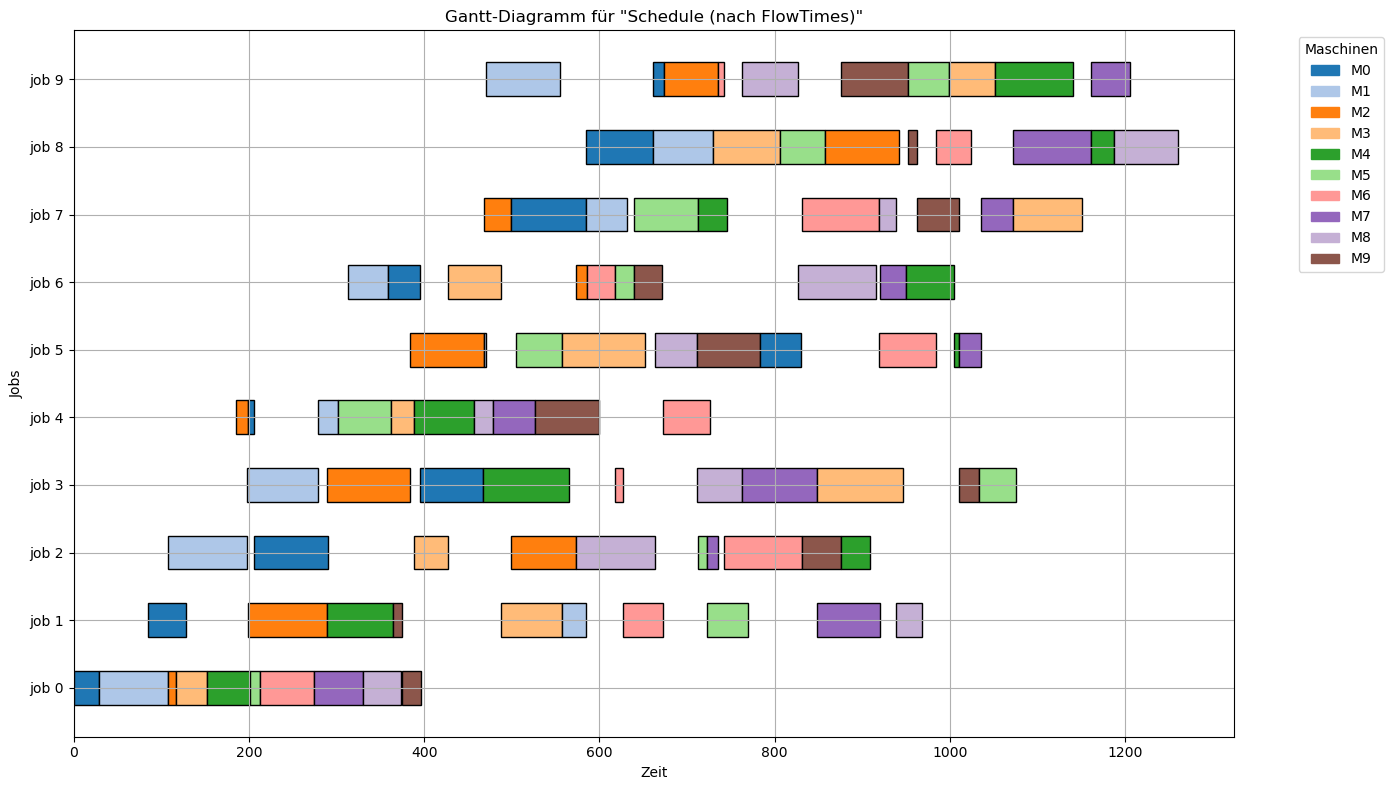

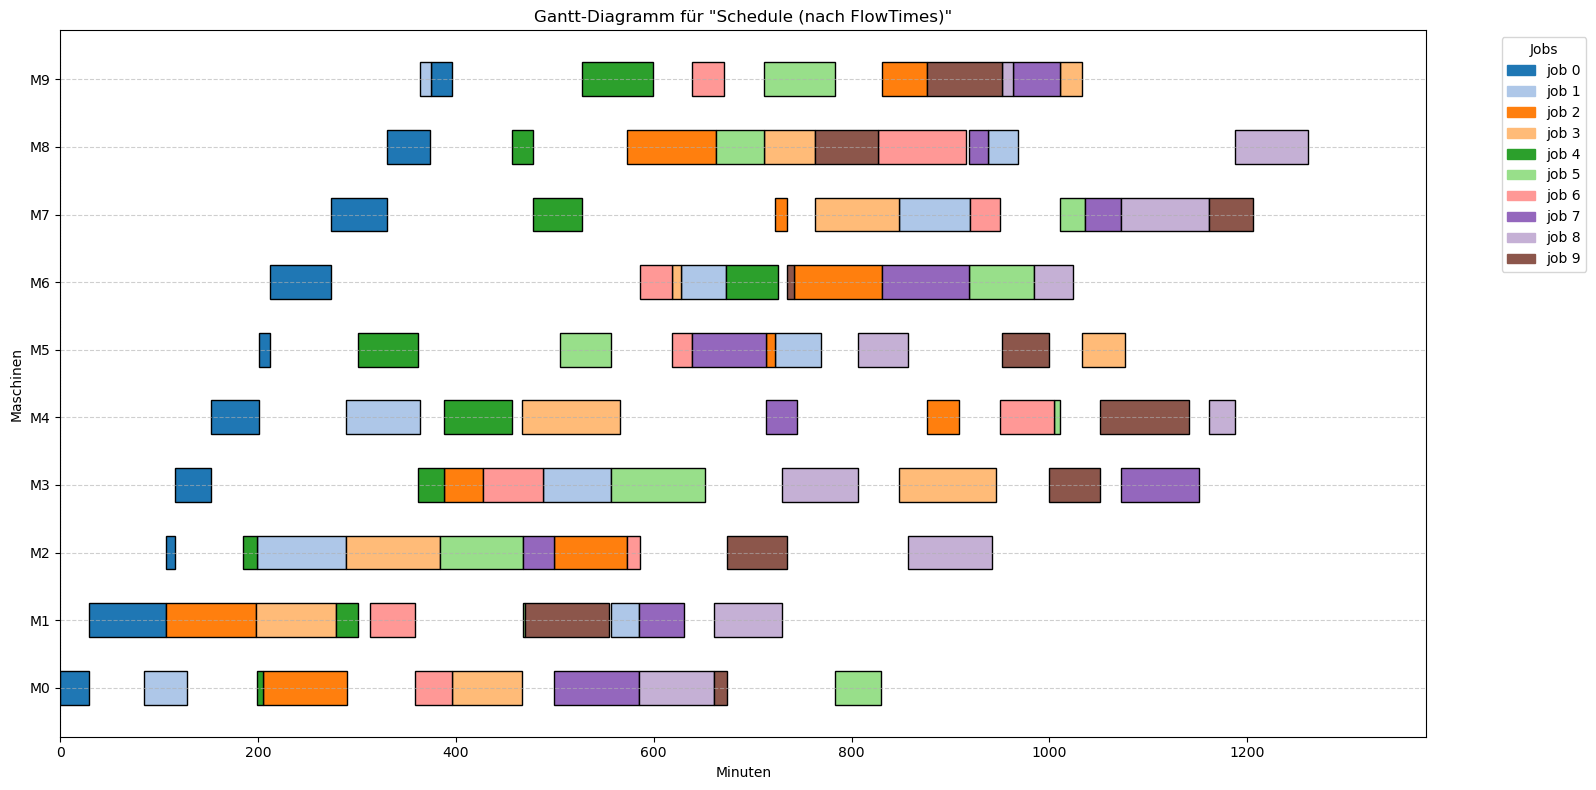

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [17]:
category = "Schedule (nach FlowTimes)"

show.plot_gantt_jobs(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))

check.check_all_constraints(df_schedule)

In [18]:
makespan_for_unweighted = df_schedule.End.max()
print(f"Makespan: {makespan_for_unweighted} Minuten")

Makespan: 1261.08 Minuten


> Solver-Dauer: 600.0s <br>Gap: 9.01%

### b) gewichtet

In [ ]:
df_schedule, _ = solve_jssp_weighted_individual_flowtime(df_instance, df_arrivals, solver_time_limit=60*limit_minutes, epsilon=0)
df_schedule

In [ ]:
category = "Schedule (nach FlowTimes gewichtet)"

show.plot_gantt_jobs(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))

check.check_all_constraints(df_schedule)

In [ ]:
makespan_for_weighted = df_schedule.End.max()
print(f"Makespan (bei gewichteten Scheduling): {makespan_for_weighted} Minuten")

> Solver-Dauer: 600.0s <br>Gap: 0.74%